# Prepare Structural Eigenmodes as regressors

This notebook computes our third geometric regressor modality.<br>
We first compute (1) group-average and (2) individual-level structural eigenmodes, and align those to the group average components.

**Inputs**

Group Average Brain Surface (aligned to FSLR32k)<br>
`data/group_average.L.midthickness.surf.gii`, from [here](https://docs.google.com/uc?export=download&id=1jCyMbcVrUtCPOxahozMrQZyUgPIyQLV8)


Indiviudal Brain Surfaces (aligned to FSLR32k)<br>
`/scratch/users/robert.scholz2/HCP_1200/{subj}/T1w/fsaverage_LR32k/{subj}.L.midthickness_MSMAll.29k.noMW.surf.gii`


**Outputs**

HCP Group Average Surface Structural Eigenmodes<br>
`data/group_avg_surf_eigenmodes.L.midthickness.npy`

HCP Individual Subject Structural Eigenmodes<br>
`/scratch/users/robert.scholz2/acc_distsall_SEmodes_254_full_unrelated.L.midthickness_MSMAll.noMW.surf.SEmodes.procAlignGrp.npy`

<br>

In [2]:
import lapy
import nibabel as nib
import numpy as np

from lapy import Solver, TriaMesh

from matplotlib import pyplot as plt
from lib.plotting import plot_29k

from brainspace.gradient.alignment import ProcrustesAlignment
from tqdm import tqdm

plt.close('all')

/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [2]:
# Laplace-Beltrami Eigenmodes stuff
def get_eigenmodes(v, t, return_evals=False, num_modes=200):
    # Eigenmodes from lapy import Solver, TriaMesh
    mesh          = TriaMesh(v, t)
    solver        = Solver(mesh)
    evals, emodes = solver.eigs(k=num_modes)
    if return_evals:
        return emodes, evals
    else:
        return emodes
    
def read_mesh(surf_file):
    """get vertices and triangles from mesh
    Returns : (vertices, triangles)
    """
    gii = nib.load(surf_file)
    return gii.darrays[0].data, gii.darrays[1].data

# Single Subject Eigenmodes

In [10]:
local_hcp_dir = "/scratch/users/robert.scholz2/HCP_1200/"
mw = '/scratch/users/robert.scholz2/HCP_1200/877269/T1w/fsaverage_LR32k/877269.L.midthickness_MSMAll.29k.noMW.surf.gii'
verts, triangs = read_mesh(mw)
verts.shape, triangs.shape

((29696, 3), (59147, 3))

In [11]:
emodes = get_eigenmodes(verts, triangs)
emodes.shape

TriaMesh with regular Laplace-Beltrami
Solver: spsolve (LU decomposition) ...


(29696, 200)

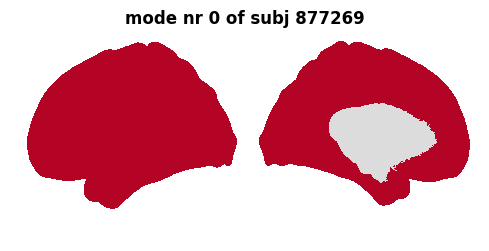

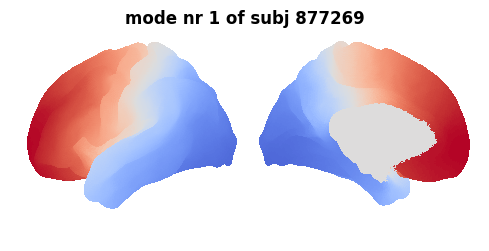

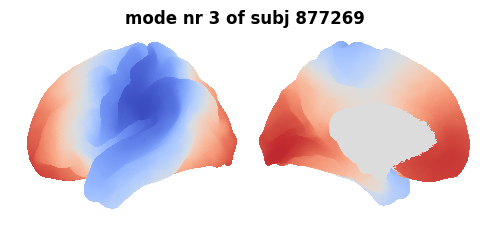

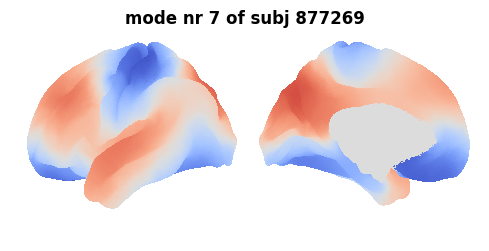

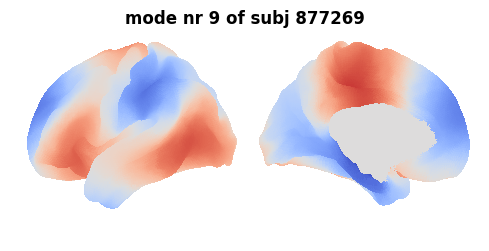

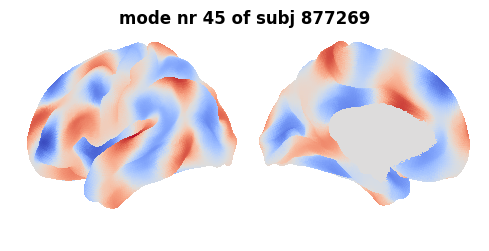

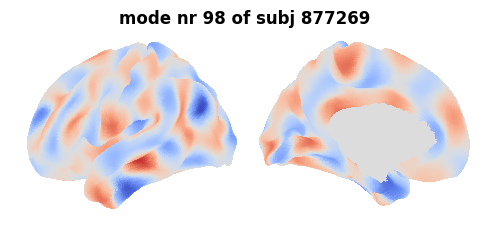

In [12]:
subj = "877269"
for mn in [0,1,3, 7, 9,  45, 98]:
  plot_29k(emodes[:,mn], title=f"mode nr {mn} of subj {subj}", colorbar=False)

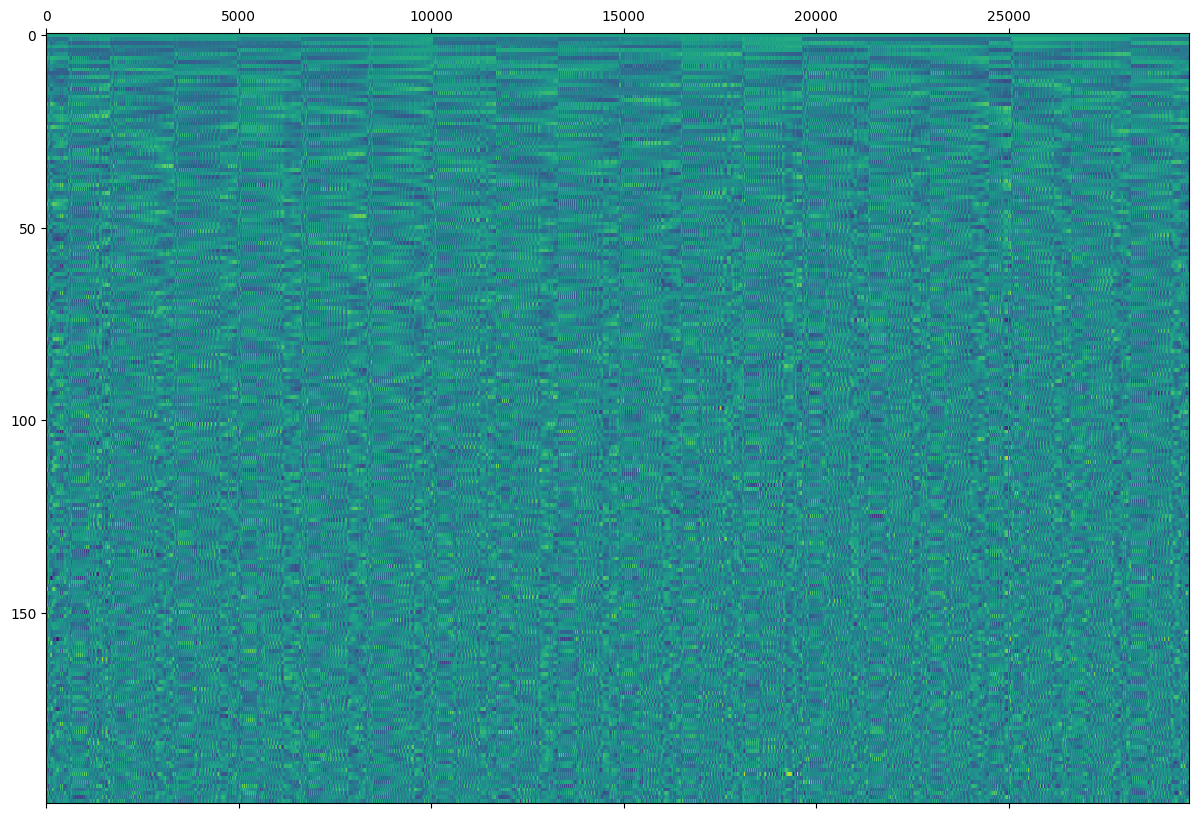

In [13]:
ax = plt.figure(figsize=(20,10)).gca()
ax.matshow(emodes.T, aspect=100)

In [79]:
#!ls /scratch/users/robert.scholz2/HCP_1200/877269/T1w/fsaverage_LR32k/
!ls /scratch/users/robert.scholz2/HCP_1200/877269/T1w/fsaverage_LR32k/877269.L.midthickness_MSMAll.29k.noMW.surf.SEmodes.npy

877269.L.midthickness.MSMAll.native.surf.29xDk.npy
877269.L.midthickness.MSMAll.native.surf.29xHMMP.npy
877269.L.midthickness.MSMAll.native.surf.29xLS08s4.npy
877269.L.midthickness.MSMAll.native.surf.29xcam_laus_08s4.centroid_dist.npy
877269.L.midthickness.MSMAll.native.surf.29xcam_laus_08s4.npy
877269.L.midthickness_MSMAll.29k.noMW.surf.gii
877269.L.midthickness_MSMAll.32k_fs_LR.surf.gii
877269.R.midthickness.MSMAll.native.surf.29xDk.npy
877269.R.midthickness.MSMAll.native.surf.29xHMMP.npy
877269.R.midthickness.MSMAll.native.surf.29xLS08s4.npy
877269.R.midthickness_MSMAll.29k.noMW.surf.gii
877269.R.midthickness_MSMAll.32k_fs_LR.surf.gii


In [82]:
# saving of the subject specific eigenmodes
fn = local_hcp_dir + f'{subj}/T1w/fsaverage_LR32k/{subj}.L.midthickness_MSMAll.29k.noMW.surf.SEmodes.npy'
np.save(fn, emodes)
!ls -ash {fn}

23M /scratch/users/robert.scholz2/HCP_1200/877269/T1w/fsaverage_LR32k/877269.L.midthickness_MSMAll.29k.noMW.surf.SEmodes.npy


# Eigenmodes of group average surface

In [4]:
# download of the group average surface
#!wget -q --no-check-certificate 'https://docs.google.com/uc?export=download&id=1jCyMbcVrUtCPOxahozMrQZyUgPIyQLV8' -O data/group_average.L.midthickness.surf.gii

In [4]:
gverts, gtriangs = read_mesh("data/group_average.L.midthickness.surf.gii")
gr_emodes = get_eigenmodes(gverts, gtriangs)
gr_emodes.shape

TriaMesh with regular Laplace-Beltrami
Solver: spsolve (LU decomposition) ...


(29696, 200)

In [5]:
np.save("data/group_avg_surf_eigenmodes.L.midthickness.npy", gr_emodes)

# Batch generation of Eigenmodes

In [86]:
import os
from tqdm import tqdm
from IPython.display import clear_output

full_subjs=np.loadtxt("data/subjs_hcp254_full_unrelated.txt").astype(int).astype(str);
print(full_subjs[:4])
local_hcp_dir = "/scratch/users/robert.scholz2/HCP_1200/"##

#shape = [len(full_subjs)] + list(emodes.shape)
#all_emodes = np.zeros(shape)
#print(all_emodes.shape)
all_emodes = {}

for i, subj in tqdm(enumerate(full_subjs), total = len(full_subjs)):
  print(i, subj, end=" ")
  geo_file = local_hcp_dir + f'{subj}/T1w/fsaverage_LR32k/{subj}.L.midthickness_MSMAll.29k.noMW.surf.gii'
  #/scratch/users/robert.scholz2/
  #if os.path.exists(emodes_file): continue;
  verts, triangs = read_mesh(geo_file)
  #verts.shape, triangs.shape
  emodes = get_eigenmodes(verts, triangs)
  #all_emodes[i] = emodes.copy()
  all_emodes[subj] = emodes.astype(np.float32).copy()
  #np.save(emodes_file, emodes)
  clear_output(wait=True)  



100%|██████████| 254/254 [29:02<00:00,  6.86s/it]


In [164]:
fn = "/scratch/users/robert.scholz2/acc_dists/all_SEmodes_254_full_unrelated.L.midthickness_MSMAll.noMW.surf.SEmodes.unaligned.npy"
np.save(fn, all_emodes)
!ls -ash {fn}

5.7G /scratch/users/robert.scholz2/acc_dists/all_SEmodes_254_full_unrelated.L.midthickness_MSMAll.noMW.surf.SEmodes.unaligned.npy


# align to the group average surface components

In [22]:
print(gr_emodes.shape)
fn = "/scratch/users/robert.scholz2/acc_dists/all_SEmodes_254_full_unrelated.L.midthickness_MSMAll.noMW.surf.SEmodes.unaligned.npy"
all_emodes = np.load(fn, allow_pickle=1).item()
print(all_emodes["877269"].shape)

alignment = ProcrustesAlignment(verbose=False, n_iter = 10)
galign_emodes = {subj : alignment.fit([all_emodes[subj]], gr_emodes).aligned_[0].astype(np.float32) for subj in tqdm(all_emodes.keys())}

100%|██████████| 254/254 [00:54<00:00,  4.65it/s]


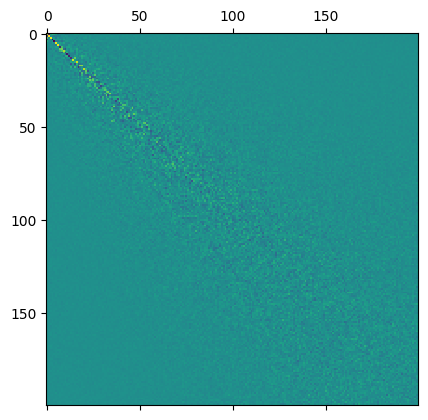

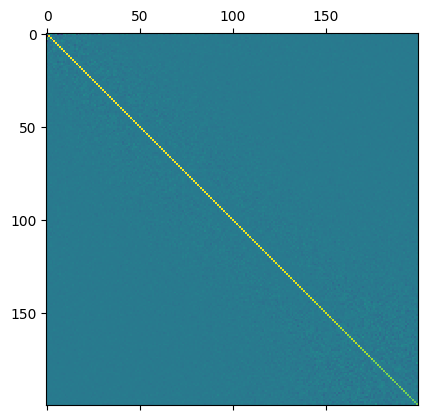

In [25]:
# showing the correlation between individual and group eigenmodes before and after alignment
cf = np.corrcoef(all_emodes["877269"].T, gr_emodes.T)[:200,200:]
plt.matshow(cf)
cf = np.corrcoef(galign_emodes["877269"].T, gr_emodes.T)[:200,200:]
plt.matshow(cf)

In [26]:
fn = "/scratch/users/robert.scholz2/acc_dists/all_SEmodes_254_full_unrelated.L.midthickness_MSMAll.noMW.surf.SEmodes.procAlignGrp.npy"
np.save(fn, galign_emodes)
!ls -ash {fn}

5.7G /scratch/users/robert.scholz2/acc_dists/all_SEmodes_254_full_unrelated.L.midthickness_MSMAll.noMW.surf.SEmodes.procAlignGrp.npy


In [ ]:
# Could be further z-scored in addition:
# galign_emodes_z = {subj : scipy.stats.zscore(galign_emodes[subj], axis=0) for subj in tqdm(galign_emodes.keys())}

# Alternatives

## Sort Flip Alignment 
(does only seem to work between individuals well)

In [25]:
# do sort + flip alingment
import scipy.stats
# load raw components
print(gr_emodes.shape)
fn = "/scratch/users/robert.scholz2/acc_dists/all_SEmodes_254_full_unrelated.L.midthickness_MSMAll.noMW.surf.SEmodes.unaligned.npy"
#all_emodes = np.load(fn, allow_pickle=1).item()
print(all_emodes["877269"].shape)

def sort_flip__proc_alignment(emodes2, emodes1):
  # align emodes2 to emodes1
  taken = []
  cmat = np.corrcoef(emodes1.T, emodes2.T)[:200,200:];
  emodes2sf = emodes2.copy()

  for i in range(199):
    corr_values = cmat[1:,1:][i,:];
    sorted_max=np.argsort(np.absolute(corr_values))
    for j in sorted_max:
      if not (j in sorted_max): break;
  
    r=corr_values[j].round(2);
    emodes2sf[:, i+1] = emodes2[:, j+1] if r>=0 else -emodes2[:, j+1]
  
  # refinement of not well fitted components
  corr2 = np.diag(np.corrcoef(emodes1.T, emodes2sf.T)[:200,200:])
  n2ba = corr2 < 0.95  #needs to be aligned?
  #n2ba = np.arange(200)>0
  alignment = ProcrustesAlignment(verbose=False, n_iter = 10)
  emodes2fa1 = alignment.fit([emodes2sf[:,n2ba]], emodes1[:,n2ba]).aligned_[0]
  emodes2fa2 = emodes2sf.copy()
  emodes2fa2[:, n2ba] = emodes2fa1
  return emodes2sf

#sfa_emodes = {subj : sort_flip_alignment(all_emodes[subj], gr_emodes).astype(np.float32) for subj in tqdm(all_emodes.keys())}
sfa_emodes = {subj : scipy.stats.zscore(sort_flip_alignment(all_emodes[subj], gr_emodes).astype(np.float32), axis=0).astype(np.float32)  for subj in tqdm(all_emodes.keys())}

#sfa_emodes = {subj : sort_flip_alignment(all_emodes[subj], all_emodes['100206']).astype(np.float32) for subj in tqdm(all_emodes.keys())}

(29696, 200)
(29696, 200)



100%|██████████| 254/254 [01:29<00:00,  2.83it/s]


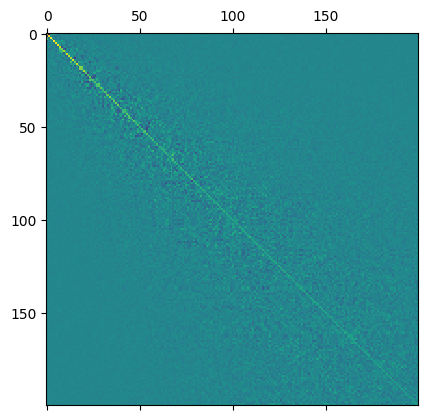

In [28]:
cmat = np.corrcoef(sfa_emodes["877269"].T, gr_emodes.T)[:200,200:];
plt.matshow(cmat)

In [29]:
fn = "/scratch/users/robert.scholz2/acc_dists/all_SEmodes_254_full_unrelated.L.midthickness_MSMAll.noMW.surf.SEmodes.SFprocAlignGrp.zscore.npy"
np.save(fn, sfa_emodes)

## Finding a good alignment procedure 

In [15]:
subj = '100206'
emodes1 = np.load(local_hcp_dir + f'{subj}/T1w/fsaverage_LR32k/{subj}.L.midthickness_MSMAll.29k.noMW.surf.SEmodes.npy')
subj = '101309'
emodes2 = np.load(local_hcp_dir + f'{subj}/T1w/fsaverage_LR32k/{subj}.L.midthickness_MSMAll.29k.noMW.surf.SEmodes.npy')

emodes1.shape

(29696, 200)

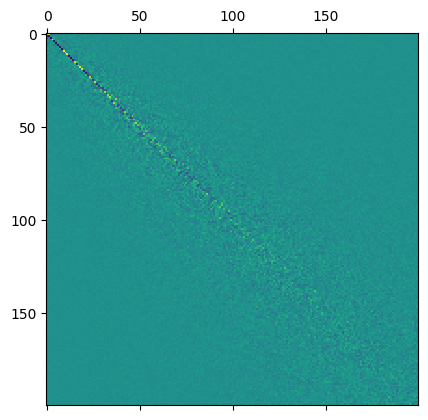

In [18]:
cf = np.corrcoef(emodes1.T, emodes2.T)[:200,200:]
plt.matshow(cf)

In [96]:
emodes.shape

(29696, 200)

In [6]:
from lib.utils import get_machine_stats
get_machine_stats(verb=1, gpu=0, ret=0, sep="  ", proc=1, rnd=2, per_cpu=1)

cpu: 1.4%  vmem: 18.0%  vmem_tot: 376.56gb  n_cpus: 96  pid: 168694  proc_mem: 0.31gb  proc_mem/tot: 0.08%  proc_n_cpus: 12  proc_cum_cpu: 0.0%  proc_avg_cpu: 0.0%  proc_assigned_cpus: [13, 14, 15, 33, 34, 35, 57, 58, 59, 81, 82, 83]  assigned_cpu_util_%: [10.1 10.1 12.4 10.1 10.3 10.1 10.1 10.1 10.1 10.7 10.5  9.9]


<BarContainer object of 200 artists>

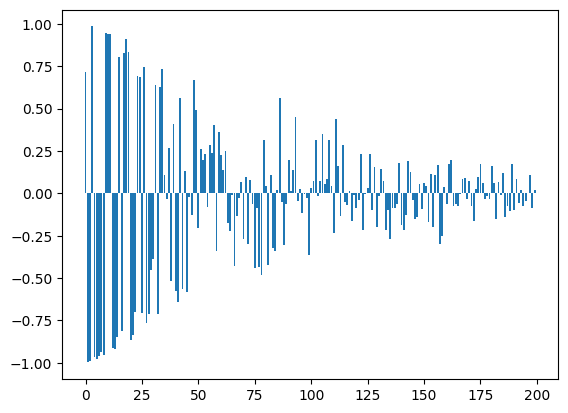

In [24]:
# unaligned correlation two subjects eigenmodes
corr = np.diag(np.corrcoef(emodes1.T, emodes2.T)[:200,200:])
plt.bar(np.arange(200), corr)

<BarContainer object of 200 artists>

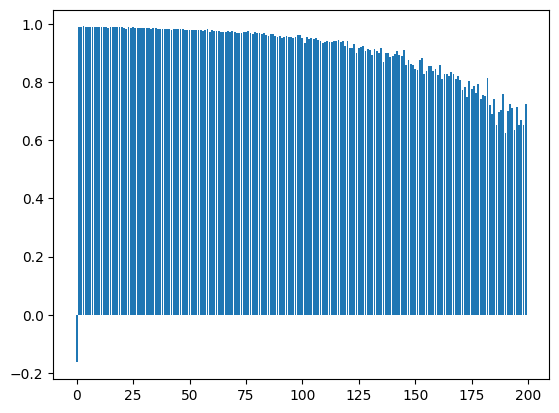

In [128]:
# standard procrustes alignment ...

alignment = ProcrustesAlignment(verbose=False, n_iter = 10)
#allGradsAlignedObject = alignment.fit([emodes2.T], emodes1.T) 
allGradsAlignedObject = alignment.fit([emodes2], emodes1) 
#emodes2a = allGradsAlignedObject.aligned_[0].T
emodes2a = allGradsAlignedObject.aligned_[0]

corr = np.diag(np.corrcoef(emodes1.T, emodes2a.T)[:200,200:])
plt.bar(np.arange(200), corr)

<BarContainer object of 200 artists>

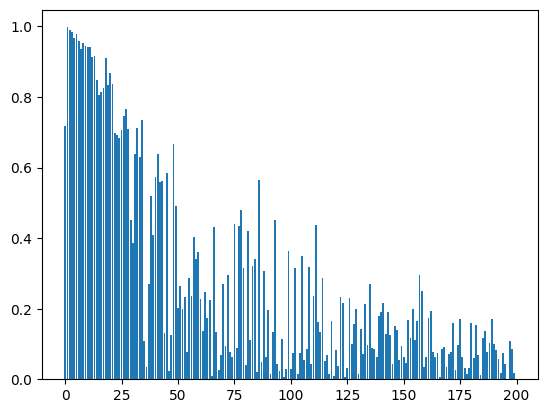

In [125]:
# flip-alignment
corr = np.diag(np.corrcoef(emodes1.T, emodes2.T)[:200,200:])
emodes2f = np.zeros_like(emodes2)
for m, r in enumerate(corr):
  emodes2f[:, m] = emodes2[:, m] if r>= 0 else emodes2[:, m]*-1;

corr2 = np.diag(np.corrcoef(emodes1.T, emodes2f.T)[:200,200:])
plt.bar(np.arange(200), corr2)

<BarContainer object of 200 artists>

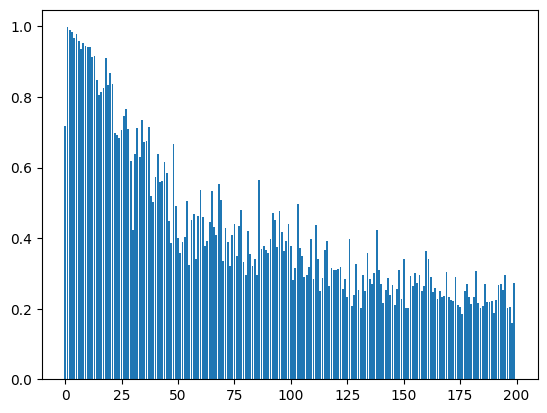

In [126]:
# sorting + flip-alignment
taken = []
cmat = np.corrcoef(emodes1.T, emodes2.T)[:200,200:];
emodes2sf = emodes2.copy()

for i in range(199):
  corr_values = cmat[1:,1:][i,:];
  sorted_max=np.argsort(np.absolute(corr_values))
  for j in sorted_max:
    if not (j in sorted_max): break;
  
  r=corr_values[j].round(2);
  #print(i, j, r, end=" | ")
  emodes2sf[:, i+1] = emodes2[:, j+1] if r>=0 else -emodes2[:, j+1]

corr = np.diag(np.corrcoef(emodes1.T, emodes2sf.T)[:200,200:])
plt.bar(np.arange(200), corr)

<BarContainer object of 200 artists>

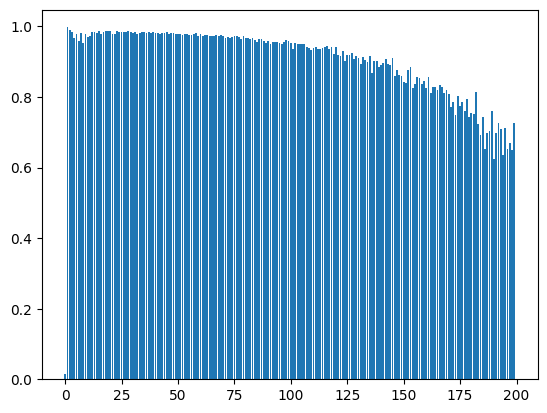

In [129]:
# selective procrustes alignment
alignment = ProcrustesAlignment(verbose=False, n_iter = 10)
corr2 = np.diag(np.corrcoef(emodes1.T, emodes2f.T)[:200,200:])
n2ba = corr2 < 0.95  #needs to be aligned?
#n2ba = np.arange(200)>0
emodes2fa1 = alignment.fit([emodes2[:,n2ba]], emodes1[:,n2ba]).aligned_[0]
emodes2fa2 = emodes2f.copy()
emodes2fa2[:, n2ba] = emodes2fa1
np.where(n2ba)

corr = np.diag(np.corrcoef(emodes1.T, emodes2fa2.T)[:200,200:])
plt.bar(np.arange(200), corr)

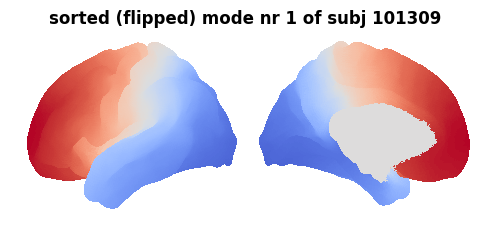

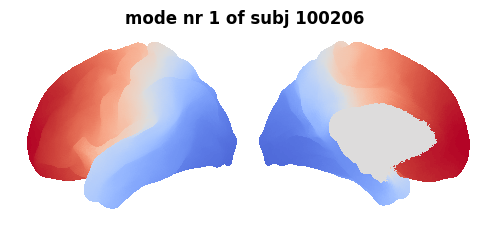

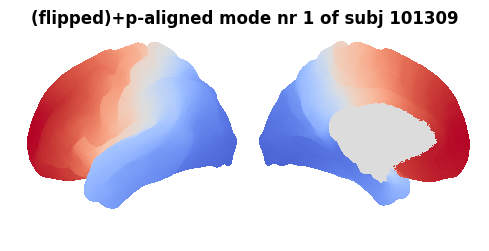

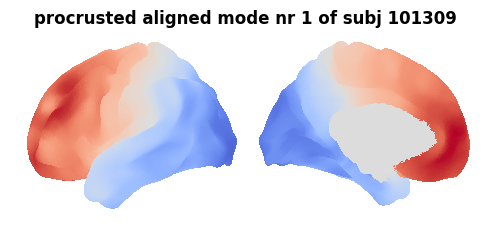

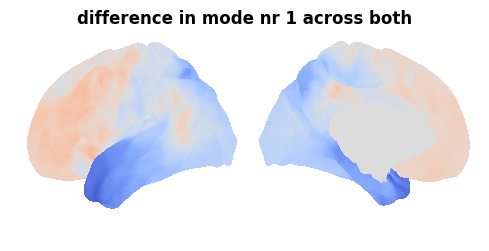

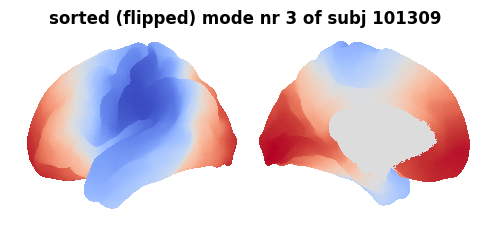

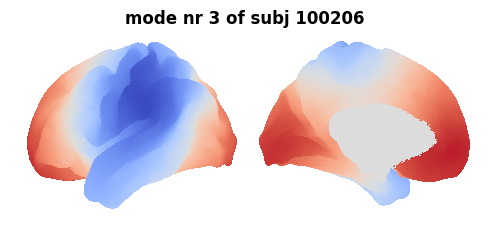

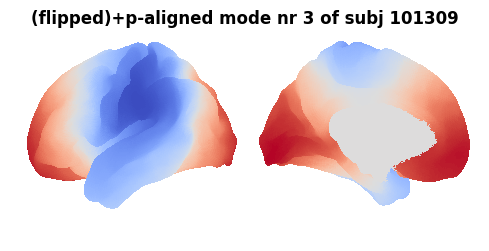

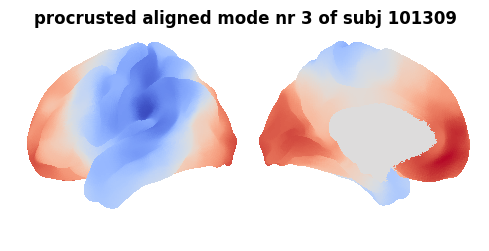

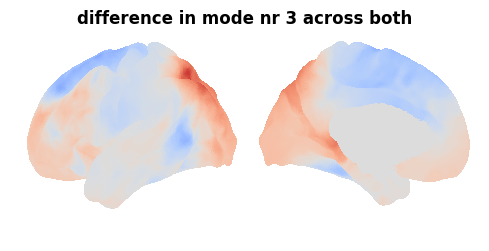

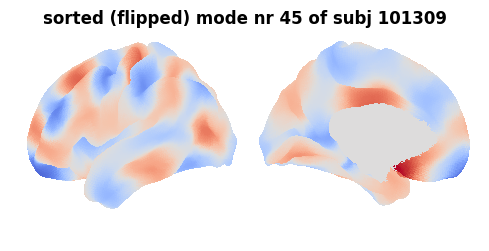

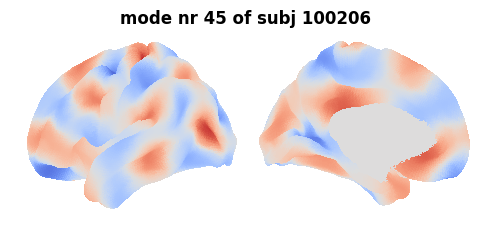

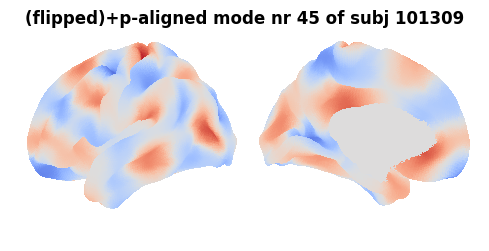

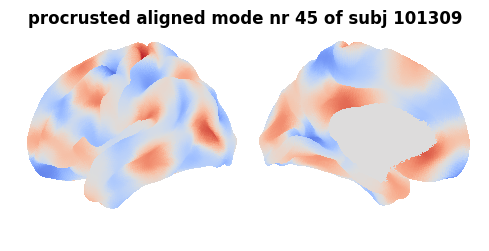

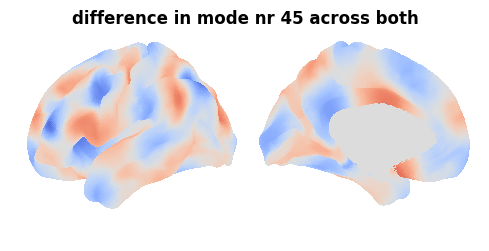

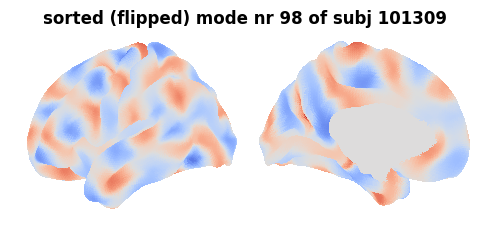

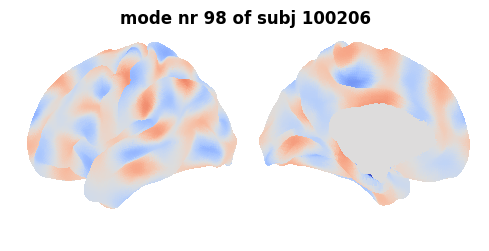

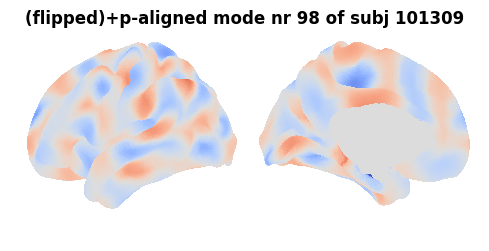

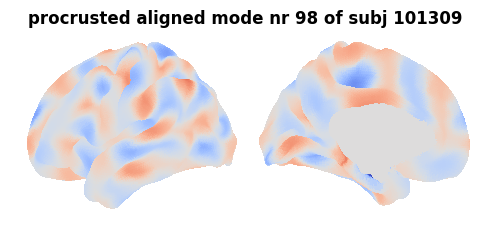

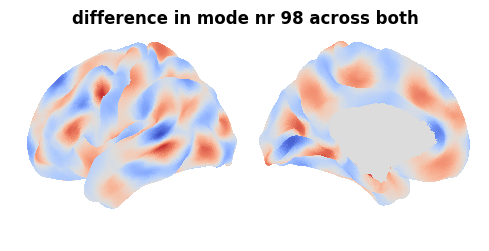

In [133]:
for mn in [1,3, 45, 98]:
  plot_29k(emodes2sf[:,mn], title=f"sorted (flipped) mode nr {mn} of subj 101309", colorbar=False)
  plot_29k(emodes1[:,mn], title=f"mode nr {mn} of subj 100206", colorbar=False)
  plot_29k(emodes2fa2[:,mn], title=f"(flipped)+p-aligned mode nr {mn} of subj 101309", colorbar=False)
  plot_29k(emodes2a[:,mn], title=f"procrusted aligned mode nr {mn} of subj 101309", colorbar=False)
  plot_29k(emodes2f[:,mn]-emodes1[:,mn], title=f"difference in mode nr {mn} across both", colorbar=False)
    